## Welcome to an initial exploration of a Zillow dataset for Single-Family Properties in Southern California, specifically Los Angeles, Orange, and Ventura Counties

Rich Alcabes, Zillow DS Team Member

In [1]:
#standard ds imports
import pandas as pd
import numpy as np
#viz and stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# .py imports
from env import user, pwd,host
import env
import wrangle_zillow as wz
import os
#sklearn imports
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.metrics import r2_score
#CATboost imports


## OVERVIEW and GOALS:

### Using data from 3 counties in the LA metroplex, discover recommendations for refining our current model (MODEL Z) for the target Assessed_Taxable_Value of Single-Family properties based upon data drawn from those properties involved in a transaction during 2017.

- Provide recommendations for improvements upon MODEL Z, a model currently fielded by the Zillow Data Science Team.
- Subset a relatively noisy datset to extract possible signal from the noise.
- Reduce dimensionality via selection tools and identify multicolinearity.
- Identify avenues of future exploration and modeling.
- Create a Machine Learning Model which explains the greatest amount of the variance in the target feature.

## ACQUISTION and PREP: Features needed for Tax Valuation not Market Valuation

- Encoded required features
- Removed Outliers; Default 1.5 * IQR except for Beds (1-5) & Baths (1-4)
- Removed rows containing NULL values for important features
- Split data into standard ML subsets (Train/Validate/Test)
- Derived missing Year_Built data from Train and impute into Validate and Test

local version found!


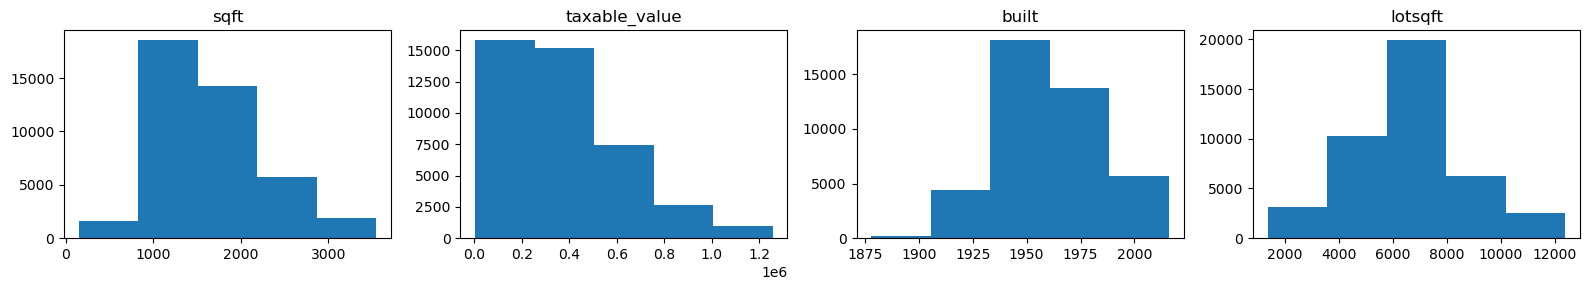

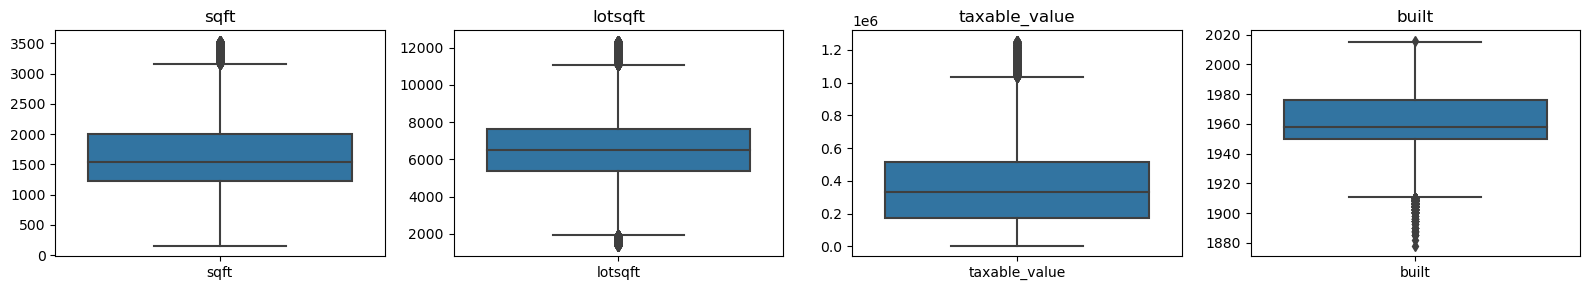

In [2]:
# Acquire/Prep/Split dataset:
train_all,validate_all,test_all = wz.wrangle_zillow()
train_all['fips'] = train_all.fips.astype(int).astype(object)
train_all['beds'] = train_all.beds.astype(int)

## EXPLORATION and HYPOTHESES:

- Imbalalance in FIPS features?
- Statistically significant difference in means for each County?
- Correlation among SQFT, BEDS, and BATHS?
- Distribution of Target feature when subset by County?

### FIPS Datapoints in Train:
- (6037)  LA Cnty:      ~15k
- (6059)  Orange Cnty:  ~ 6k
- (6111)  Ventura Cnty: ~ 2k

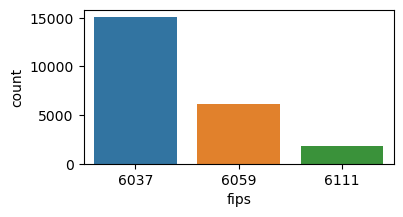

6037    15085
6059     6179
6111     1872
Name: fips, dtype: int64

In [3]:
# Barchart to show disparity in FIPS counts:
plt.figure(figsize=(4,2))
sns.countplot(train_all['fips'])
plt.show()
train_all.fips.value_counts()

### Mean taxable_value by FIPS:
- (6037)  LA Cnty:      ~ 334k
- (6059)  Orange Cnty:  ~ 447k
- (6111)  Ventura Cnty: ~ 409k

- OVERALL MEAN: ~ 370k



In [4]:
#output each mean and overall mean:
print(f'LA CNTY: {round(train_all[train_all.fips == 6037].taxable_value.mean(),0)}')
print(f'ORANGE CNTY: {round(train_all[train_all.fips == 6059].taxable_value.mean(),0)}')
print(f'VENTURA CNTY: {round(train_all[train_all.fips == 6111].taxable_value.mean(),0)}')
print(f'OVERALL: {round(train_all.taxable_value.mean(),0)}')

LA CNTY: 333879.0
ORANGE CNTY: 447286.0
VENTURA CNTY: 409160.0
OVERALL: 370258.0


## Does a statistically significant difference exist between mean Taxable_Value in LA CNTY and that of the OVERALL sample?
### T-Test Independence 1-sample, 2-tail

## Due to CentralLimitTheorem and large sample size( > 500): assumption of "normality" is no longer necessary

### Hypothesis

- ${H_0}$: No statistically significant difference exists between mean Taxable_Values in LA County and the mean of all counties.
- ${H_a}$: A statistically significant difference exists between mean Taxable_Values in LA County and the mean of all counties.

#### Two-tailed, One-Sample T-Test ANY DIFF in mean between a subset and overall

In [7]:
α = 0.05
lacnty_taxable_values = train_all[train_all.fips == 6037].taxable_value
overall_mean = train_all.taxable_value.mean()
t, p = stats.ttest_1samp(lacnty_taxable_values,overall_mean)
print(t,p,α)
print(f'p = {p:e}')

-18.26322060553196 1.0105590708760435e-73 0.05
p = 1.010559e-73


# Reject the NULL
### A statistically significant difference exists, there is evidence to suggest that the two samples were drawn from two distinct distributions.

---
---

## Does a statistically significant correlation exist between SQFT feature and Baths feature values?
### Pearson's R for linear correlation


### Hypothesis

- ${H_0}$: No statistically significant correlation exists between SQFT values in all counties and Baths values in all counties.
- ${H_a}$: A statistically significant correlation exists between SQFT values in all counties and Baths values in all counties.


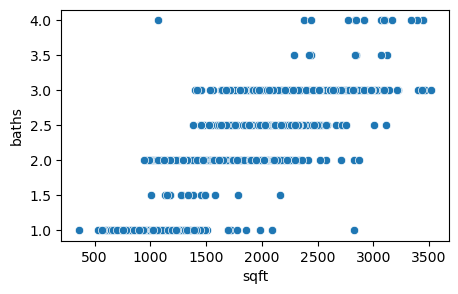

In [8]:
# Depict the relationship between SQFT and Baths
train_1000 = train_all.sample(1000)
plt.figure(figsize=(5,3))
sns.scatterplot(data=train_1000, x='sqft',y='baths')
plt.show()

In [9]:
α = 0.05
sqft_col = train_all.sqft
baths_col = train_all.baths
r, p = stats.pearsonr(sqft_col,baths_col)
print(r,p,α)
print(f'p = {p:e}')

0.7754775107376679 0.0 0.05
p = 0.000000e+00


# Reject the NULL
### A statistically significant correlation exists, there is evidence to suggest that the observed correlation is due to something other than random sampling.
## r = ~ 0.78

---
---

## Does a statistically significant correlation exist between SQFT feature and Taxable_Value feature values?
### Pearson's R for linear correlation


### Hypothesis

- ${H_0}$: No statistically significant correlation exists between SQFT values in all counties and Taxable_Values in all counties.
- ${H_a}$: A statistically significant correlation exists between SQFT values in all counties and Taxable_Values in all counties.


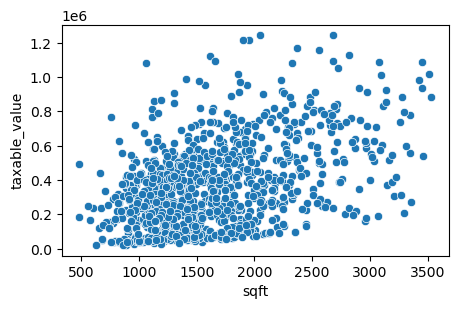

In [10]:
# Depict the relationship between SQFT and Baths
train_1000 = train_all.sample(1000)
plt.figure(figsize=(5,3))
sns.scatterplot(data=train_1000, x='sqft',y='taxable_value')
plt.show()

In [11]:
α = 0.05
sqft_col = train_all.sqft
tax_col = train_all.taxable_value
r, p = stats.pearsonr(sqft_col,tax_col)
print(r,p,α)
print(f'p = {p:e}')

0.4408769654386143 0.0 0.05
p = 0.000000e+00


# Reject the NULL
### A statistically significant correlation exists, there is evidence to suggest that the observed correlation is due to something other than random sampling.
## r = ~ 0.44

In [ ]:
# Subset the data into LA County ONLY:
train = train_all[train_all['fips'] == 6037]
validate = validate_all[validate_all['fips'] == 6037]
test = test_all[test_all['fips'] == 6037]

In [ ]:
# Create a feature which combines SQFT-BEDS-BATHS to remove multicolinearity.
train['o_sqft'] = round(train['sqft'] / (train.beds + train.baths),0)
validate['o_sqft'] = round(validate['sqft'] / (validate.beds + validate.baths),0)
test['o_sqft'] = round(test['sqft'] / (test.beds + test.baths),0)